In [1]:
import torch, time, random, math, os, sys, tqdm
from torch import nn, optim
import torch.nn.functional as F
from trainer.classification import Trainer
import matplotlib.pyplot as plt

In [2]:
trainer = Trainer(batch_size=8)
trainer.load()

100%|██████████| 7600/7600 [00:00<00:00, 205404.41it/s]


Classification Dataset Stat.: name:AG_NEWS, nclass:5, max_len:1012, avg_len:236.477525, count:120000
Classification Dataset Stat.: name:AG_NEWS, nclass:5, max_len:892, avg_len:235.2992105263158, count:7600


Some weights of the model checkpoint at google/bert_uncased_L-4_H-256_A-4 were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Trainer.__init__: Model initialized. model = bert
Trainer.load: Loading...


In [3]:
batch = trainer.get_batch()
trainer.model = trainer.model.eval()
bert = trainer.model.bert
fc = trainer.model.classifier

def eval(model, batch=batch, fc=fc):
    lm_output = model(
        input_ids = batch.input_ids, 
        attention_mask = batch.attention_masks, 
        output_hidden_states=True,
        output_attentions=True,
    )
    last_hidden = lm_output.last_hidden_state[:,0,:]
    x = fc(last_hidden)
    return torch.argmax(x, dim=-1), batch.labels, lm_output
output, labels, lm_output = eval(bert)

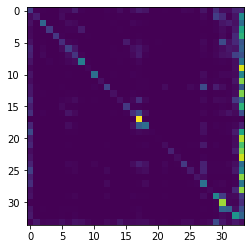

(1.0, 34, torch.Size([8, 4, 71, 71]))

In [4]:
LAYER = -1
BATCH = 0
HEAD = 0
N = torch.sum(batch.attention_masks[BATCH]).item()

plt.imshow(lm_output.attentions[LAYER][BATCH][HEAD][:N, :N].detach().cpu().numpy())
plt.show()

torch.sum(lm_output.attentions[LAYER][BATCH][HEAD][0,:N]).item(), N, lm_output.attentions[0].shape

impact factor torch.Size([34])
hign impact [33  0 27 18  7]
0.01699972152709961
tensor([33,  0, 27, 18,  7, 17, 12, 29, 24, 32], device='cuda:0')


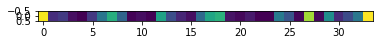

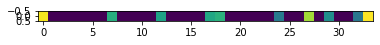

tensor([ 0, 27, 33, 14, 31, 21, 16,  6, 18, 29,  8, 25,  5,  7, 32, 13, 28, 17,
         1,  4], device='cuda:0')


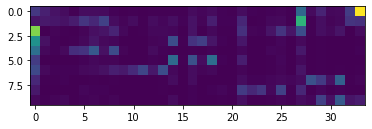

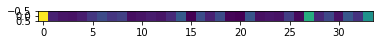

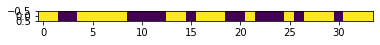

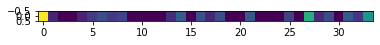

In [5]:
NBATCH = batch.input_ids.shape[0]
LAYER = 3
attend_tokens = [0]

a = lm_output.attentions[LAYER][BATCH][:,:N, :N]
a = torch.sum(a, dim=0)
a = a[attend_tokens,:]
a = torch.sum(a, dim=0)
print('impact factor', a.shape)
b = torch.topk(a, 5)[1]
print('hign impact', b.cpu().numpy())
# plt.bar(range(N), a.detach().cpu().numpy())
# plt.show()

#this is very evil code...
def update_input_mask_from_previous_attention(attention_mask, previous_attention, output_token_indices, output_token_impact, k=5):
    NBATCH = attention_mask.shape[0]

    input_indcies = []
    input_impacts = []
    for i, idxs in enumerate(output_token_indices):
        N = int(torch.sum((attention_mask[i]==0)*1.0).item())
        
        #print(i, previous_attention, N)
        a = previous_attention[i,:,:N,:N]
        #print(a.shape, N, previous_attention.shape)
        a = torch.sum(a, dim=0)
        #print(idxs, a.shape)
        a = a[idxs, :] * output_token_impact[i].view(-1, 1)
        a = torch.sum(a, dim=0)
        
        #print(f'k {k}, a {a.shape}')
        kxx = k
        if k < 1.0: kxx = int(math.ceil(k*N))
        b, c = torch.topk(a, min(N, kxx))
        input_indcies.append(c)
        input_impacts.append(b)
    
    input_mask = torch.zeros(NBATCH, attention_mask.shape[-1], device=previous_attention.device, dtype=previous_attention.dtype)
    for i, idxs in enumerate(input_indcies):
        for k in idxs:
            input_mask[i, k] = 1.0
    
    return input_mask, input_indcies, input_impacts

t = time.time()
mask, indices, impacts = update_input_mask_from_previous_attention(
    batch.attention_masks - 1.0, 
    lm_output.attentions[LAYER], 
    [[0]] * NBATCH, 
    torch.ones(NBATCH, 1, device=batch.device, dtype=torch.float32), 
    k=10
)
mask2, indices2, impacts2 = update_input_mask_from_previous_attention(
    batch.attention_masks - 1.0, 
    lm_output.attentions[LAYER-1], 
    indices, 
    impacts, 
    k=20
)
print(time.time() - t)
mask2.shape, batch.attention_masks.shape
def plot_grid(grid):
    plt.imshow(grid.cpu().detach().numpy())
    #plt.colorbar()
    plt.show()

print(indices[0])
last_output_attentions = torch.sum(lm_output.attentions[LAYER][0], dim=0)[[0], :N]
plot_grid(last_output_attentions)
last_output_attentions_input_masked = last_output_attentions * mask[0][:N]
plot_grid(last_output_attentions_input_masked)

print(indices2[0])
second_output_attentions = torch.sum(lm_output.attentions[LAYER-1][0], dim=0)[indices[0],:N]*impacts[0].view(-1,1)
plot_grid(second_output_attentions)
second_output_attentions_impact = torch.sum(second_output_attentions, dim=0).view(1,-1)
plot_grid(second_output_attentions_impact)
plot_grid(mask2[0][:N].view(1,-1))
plot_grid(second_output_attentions_impact * mask2[0][:N])

In [96]:
import math, os, torch
import torch.utils.checkpoint
from packaging import version
from torch import nn
from transformers.activations import ACT2FN
from transformers.modeling_outputs import (
    BaseModelOutputWithPastAndCrossAttentions,
    BaseModelOutputWithPoolingAndCrossAttentions,
)
from transformers.modeling_utils import (
    PreTrainedModel,
    apply_chunking_to_forward,
    find_pruneable_heads_and_indices,
    prune_linear_layer,
)
from transformers.utils import logging
from transformers.models.bert.configuration_bert import BertConfig

logger = logging.get_logger(__name__)

from transformers.models.bert.modeling_bert import BertEmbeddings

class BertSelfAttention(nn.Module):
    def __init__(self, config, position_embedding_type=None):
        super().__init__()
        if config.hidden_size % config.num_attention_heads != 0 and not hasattr(config, "embedding_size"):
            raise ValueError(
                f"The hidden size ({config.hidden_size}) is not a multiple of the number of attention "
                f"heads ({config.num_attention_heads})"
            )

        self.num_attention_heads = config.num_attention_heads
        self.attention_head_size = int(config.hidden_size / config.num_attention_heads)
        self.all_head_size = self.num_attention_heads * self.attention_head_size

        self.query = nn.Linear(config.hidden_size, self.all_head_size)
        self.key = nn.Linear(config.hidden_size, self.all_head_size)
        self.value = nn.Linear(config.hidden_size, self.all_head_size)

        self.dropout = nn.Dropout(config.attention_probs_dropout_prob)
        self.position_embedding_type = position_embedding_type or getattr(
            config, "position_embedding_type", "absolute"
        )
        if self.position_embedding_type == "relative_key" or self.position_embedding_type == "relative_key_query":
            raise Exception('removed')

        self.is_decoder = config.is_decoder
        if self.is_decoder: raise Exception()

        self.print = True
        self.reset_input_mask()
        self.attention_masking_timing = 'after_softmax'
        self.output_masking = True
    
    def reset_input_mask(self):
        self.input_mask = None
        self.input_indices = None
        self.input_impacts = None
        self.output_mask = None
    
    def update_input_mask_from_previous_attention(self, output_token_mask, output_token_indices, output_token_impact, k):
        input_mask, input_indcies, input_impacts = update_input_mask_from_previous_attention(
            self.last_attention_mask, 
            self.last_attention_probs, 
            output_token_indices, 
            output_token_impact, 
            k
        )
        self.input_mask = input_mask
        self.input_indices = input_indcies
        self.input_impacts = input_impacts
        self.output_mask = output_token_mask
        return input_mask, input_indcies, input_impacts

    def transpose_for_scores(self, x):
        new_x_shape = x.size()[:-1] + (self.num_attention_heads, self.attention_head_size)
        x = x.view(*new_x_shape)
        return x.permute(0, 2, 1, 3)

    def forward(
        self,
        hidden_states,
        attention_mask=None,
        head_mask=None,
        encoder_hidden_states=None,
        encoder_attention_mask=None,
        past_key_value=None,
        output_attentions=False,
    ):
        if self.is_decoder: raise Exception()
        if not self.attention_masking_timing in ['after_softmax', 'before_softmax']: raise Exception()
        self.last_hidden_states = hidden_states
        mixed_query_layer = self.query(hidden_states)
        
        is_cross_attention = encoder_hidden_states is not None

        if (is_cross_attention and past_key_value is not None) or is_cross_attention or (past_key_value is not None):
            raise Exception()
        else:
            key_layer = self.transpose_for_scores(self.key(hidden_states))
            value_layer = self.transpose_for_scores(self.value(hidden_states))

        query_layer = self.transpose_for_scores(mixed_query_layer)

        # Take the dot product between "query" and "key" to get the raw attention scores.
        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))

        if self.position_embedding_type == "relative_key" or self.position_embedding_type == "relative_key_query":
            raise Exception()

        attention_scores = attention_scores / math.sqrt(self.attention_head_size)
        if attention_mask is not None:
            attention_scores = attention_scores + attention_mask

        if self.input_mask is not None and self.attention_masking_timing == 'before_softmax':
            if self.print: print(f'apply input mask, before softmax. input_mask:{self.input_mask.shape}, attention_scores:{attention_scores.shape}')
            attention_scores = attention_scores + (1.0 - self.input_mask.view(self.input_mask.shape[0], 1, 1, self.input_mask.shape[-1])) * -10000

        # Normalize the attention scores to probabilities.
        attention_probs = nn.functional.softmax(attention_scores, dim=-1)

        # This is actually dropping out entire tokens to attend to, which might
        # seem a bit unusual, but is taken from the original Transformer paper.
        attention_probs = self.dropout(attention_probs)

        # Mask heads if we want to
        if head_mask is not None:
            attention_probs = attention_probs * head_mask
        
        if self.print: print('SelfAttention.forward: last_attention_probs backuped')
        self.last_attention_probs = attention_probs.detach().clone()
        self.last_attention_mask = attention_mask.detach().clone()

        if self.input_mask is not None and self.attention_masking_timing == 'after_softmax':
            if self.print: print(f'apply input mask, after softmax. input_mask:{self.input_mask.shape}, attention_probs:{attention_probs.shape}')
            attention_probs = attention_probs * self.input_mask.view(self.input_mask.shape[0], 1, 1, self.input_mask.shape[-1])

        context_layer = torch.matmul(attention_probs, value_layer)

        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)
        context_layer = context_layer.view(*new_context_layer_shape)

        if self.output_mask is not None and self.output_masking:
            output_mask = self.output_mask.unsqueeze(-1)
            if self.print: print(f'apply output mask. mask:{output_mask.shape} context:{context_layer.shape}')
            context_layer = context_layer * output_mask

        outputs = (context_layer, attention_probs) if output_attentions else (context_layer,)
        return outputs


class BertSelfOutput(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.LayerNorm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(self, hidden_states, input_tensor):
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.LayerNorm(hidden_states + input_tensor)
        return hidden_states


class BertAttention(nn.Module):
    def __init__(self, config, position_embedding_type=None):
        super().__init__()
        self.self = BertSelfAttention(config, position_embedding_type=position_embedding_type)
        self.output = BertSelfOutput(config)
        self.pruned_heads = set()

    def prune_heads(self, heads):
        if len(heads) == 0:
            return
        heads, index = find_pruneable_heads_and_indices(
            heads, self.self.num_attention_heads, self.self.attention_head_size, self.pruned_heads
        )

        # Prune linear layers
        self.self.query = prune_linear_layer(self.self.query, index)
        self.self.key = prune_linear_layer(self.self.key, index)
        self.self.value = prune_linear_layer(self.self.value, index)
        self.output.dense = prune_linear_layer(self.output.dense, index, dim=1)

        # Update hyper params and store pruned heads
        self.self.num_attention_heads = self.self.num_attention_heads - len(heads)
        self.self.all_head_size = self.self.attention_head_size * self.self.num_attention_heads
        self.pruned_heads = self.pruned_heads.union(heads)

    def forward(
        self,
        hidden_states,
        attention_mask=None,
        head_mask=None,
        encoder_hidden_states=None,
        encoder_attention_mask=None,
        past_key_value=None,
        output_attentions=False,
    ):
        self_outputs = self.self(
            hidden_states,
            attention_mask,
            head_mask,
            encoder_hidden_states,
            encoder_attention_mask,
            past_key_value,
            output_attentions,
        )
        attention_output = self.output(self_outputs[0], hidden_states)
        outputs = (attention_output,) + self_outputs[1:]  # add attentions if we output them
        return outputs


class BertIntermediate(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.intermediate_size)
        if isinstance(config.hidden_act, str):
            self.intermediate_act_fn = ACT2FN[config.hidden_act]
        else:
            self.intermediate_act_fn = config.hidden_act

    def forward(self, hidden_states):
        hidden_states = self.dense(hidden_states)
        hidden_states = self.intermediate_act_fn(hidden_states)
        return hidden_states


class BertOutput(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config.intermediate_size, config.hidden_size)
        self.LayerNorm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(self, hidden_states, input_tensor):
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.LayerNorm(hidden_states + input_tensor)
        return hidden_states


class BertLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.chunk_size_feed_forward = config.chunk_size_feed_forward
        self.seq_len_dim = 1
        self.attention = BertAttention(config)
        self.is_decoder = config.is_decoder
        self.add_cross_attention = config.add_cross_attention
        if self.add_cross_attention:
            if not self.is_decoder:
                raise ValueError(f"{self} should be used as a decoder model if cross attention is added")
            self.crossattention = BertAttention(config, position_embedding_type="absolute")
        self.intermediate = BertIntermediate(config)
        self.output = BertOutput(config)

    def forward(
        self,
        hidden_states,
        attention_mask=None,
        head_mask=None,
        encoder_hidden_states=None,
        encoder_attention_mask=None,
        past_key_value=None,
        output_attentions=False,
    ):
        # decoder uni-directional self-attention cached key/values tuple is at positions 1,2
        self_attn_past_key_value = past_key_value[:2] if past_key_value is not None else None
        self_attention_outputs = self.attention(
            hidden_states,
            attention_mask,
            head_mask,
            output_attentions=output_attentions,
            past_key_value=self_attn_past_key_value,
        )
        self.self_attention_outputs = self_attention_outputs
        attention_output = self_attention_outputs[0]

        # if decoder, the last output is tuple of self-attn cache
        if self.is_decoder: raise Exception()
        else: outputs = self_attention_outputs[1:]  # add self attentions if we output attention weights

        cross_attn_present_key_value = None
        if self.is_decoder and encoder_hidden_states is not None: raise Exception()

        layer_output = apply_chunking_to_forward(
            self.feed_forward_chunk, self.chunk_size_feed_forward, self.seq_len_dim, attention_output
        )
        self.layer_output = layer_output
        outputs = (layer_output,) + outputs

        # if decoder, return the attn key/values as the last output
        if self.is_decoder: raise Exception()

        return outputs

    def feed_forward_chunk(self, attention_output):
        intermediate_output = self.intermediate(attention_output)
        layer_output = self.output(intermediate_output, attention_output)
        return layer_output


class BertEncoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.layer = nn.ModuleList([BertLayer(config) for _ in range(config.num_hidden_layers)])
        self.gradient_checkpointing = False

    def forward(
        self,
        hidden_states,
        attention_mask=None,
        head_mask=None,
        encoder_hidden_states=None,
        encoder_attention_mask=None,
        past_key_values=None,
        use_cache=None,
        output_attentions=False,
        output_hidden_states=False,
        return_dict=True,
    ):
        all_hidden_states = () if output_hidden_states else None
        all_self_attentions = () if output_attentions else None
        all_cross_attentions = () if output_attentions and self.config.add_cross_attention else None

        next_decoder_cache = () if use_cache else None
        for i, layer_module in enumerate(self.layer):
            if output_hidden_states:
                all_hidden_states = all_hidden_states + (hidden_states,)

            layer_head_mask = head_mask[i] if head_mask is not None else None
            past_key_value = past_key_values[i] if past_key_values is not None else None

            if self.gradient_checkpointing and self.training:

                if use_cache:
                    logger.warning(
                        "`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`..."
                    )
                    use_cache = False

                def create_custom_forward(module):
                    def custom_forward(*inputs):
                        return module(*inputs, past_key_value, output_attentions)

                    return custom_forward

                layer_outputs = torch.utils.checkpoint.checkpoint(
                    create_custom_forward(layer_module),
                    hidden_states,
                    attention_mask,
                    layer_head_mask,
                    encoder_hidden_states,
                    encoder_attention_mask,
                )
            else:
                layer_outputs = layer_module(
                    hidden_states,
                    attention_mask,
                    layer_head_mask,
                    encoder_hidden_states,
                    encoder_attention_mask,
                    past_key_value,
                    output_attentions,
                )

            hidden_states = layer_outputs[0]
            if use_cache:
                next_decoder_cache += (layer_outputs[-1],)
            if output_attentions:
                all_self_attentions = all_self_attentions + (layer_outputs[1],)
                if self.config.add_cross_attention:
                    all_cross_attentions = all_cross_attentions + (layer_outputs[2],)

        if output_hidden_states:
            all_hidden_states = all_hidden_states + (hidden_states,)

        if not return_dict:
            return tuple(
                v
                for v in [
                    hidden_states,
                    next_decoder_cache,
                    all_hidden_states,
                    all_self_attentions,
                    all_cross_attentions,
                ]
                if v is not None
            )
        return BaseModelOutputWithPastAndCrossAttentions(
            last_hidden_state=hidden_states,
            past_key_values=next_decoder_cache,
            hidden_states=all_hidden_states,
            attentions=all_self_attentions,
            cross_attentions=all_cross_attentions,
        )


class BertPooler(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.activation = nn.Tanh()

    def forward(self, hidden_states):
        # We "pool" the model by simply taking the hidden state corresponding
        # to the first token.
        first_token_tensor = hidden_states[:, 0]
        pooled_output = self.dense(first_token_tensor)
        pooled_output = self.activation(pooled_output)
        return pooled_output


class BertPreTrainedModel(PreTrainedModel):
    """
    An abstract class to handle weights initialization and a simple interface for downloading and loading pretrained
    models.
    """

    config_class = BertConfig
    #load_tf_weights = load_tf_weights_in_bert
    base_model_prefix = "bert"
    supports_gradient_checkpointing = True
    _keys_to_ignore_on_load_missing = [r"position_ids"]

    def _init_weights(self, module):
        """Initialize the weights"""
        if isinstance(module, nn.Linear):
            # Slightly different from the TF version which uses truncated_normal for initialization
            # cf https://github.com/pytorch/pytorch/pull/5617
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)

    def _set_gradient_checkpointing(self, module, value=False):
        if isinstance(module, BertEncoder):
            module.gradient_checkpointing = value


class BertModel(BertPreTrainedModel):
    """

    The model can behave as an encoder (with only self-attention) as well as a decoder, in which case a layer of
    cross-attention is added between the self-attention layers, following the architecture described in [Attention is
    all you need](https://arxiv.org/abs/1706.03762) by Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit,
    Llion Jones, Aidan N. Gomez, Lukasz Kaiser and Illia Polosukhin.

    To behave as an decoder the model needs to be initialized with the `is_decoder` argument of the configuration set
    to `True`. To be used in a Seq2Seq model, the model needs to initialized with both `is_decoder` argument and
    `add_cross_attention` set to `True`; an `encoder_hidden_states` is then expected as an input to the forward pass.
    """

    def __init__(self, config, add_pooling_layer=True):
        super().__init__(config)
        self.config = config

        self.embeddings = BertEmbeddings(config)
        self.encoder = BertEncoder(config)

        self.pooler = BertPooler(config) if add_pooling_layer else None

        # Initialize weights and apply final processing
        self.post_init()

    def get_input_embeddings(self):
        return self.embeddings.word_embeddings

    def set_input_embeddings(self, value):
        self.embeddings.word_embeddings = value

    def _prune_heads(self, heads_to_prune):
        """
        Prunes heads of the model. heads_to_prune: dict of {layer_num: list of heads to prune in this layer} See base
        class PreTrainedModel
        """
        for layer, heads in heads_to_prune.items():
            self.encoder.layer[layer].attention.prune_heads(heads)
            
    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        encoder_hidden_states=None,
        encoder_attention_mask=None,
        past_key_values=None,
        use_cache=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        r"""
        encoder_hidden_states  (`torch.FloatTensor` of shape `(batch_size, sequence_length, hidden_size)`, *optional*):
            Sequence of hidden-states at the output of the last layer of the encoder. Used in the cross-attention if
            the model is configured as a decoder.
        encoder_attention_mask (`torch.FloatTensor` of shape `(batch_size, sequence_length)`, *optional*):
            Mask to avoid performing attention on the padding token indices of the encoder input. This mask is used in
            the cross-attention if the model is configured as a decoder. Mask values selected in `[0, 1]`:

            - 1 for tokens that are **not masked**,
            - 0 for tokens that are **masked**.
        past_key_values (`tuple(tuple(torch.FloatTensor))` of length `config.n_layers` with each tuple having 4 tensors of shape `(batch_size, num_heads, sequence_length - 1, embed_size_per_head)`):
            Contains precomputed key and value hidden states of the attention blocks. Can be used to speed up decoding.

            If `past_key_values` are used, the user can optionally input only the last `decoder_input_ids` (those that
            don't have their past key value states given to this model) of shape `(batch_size, 1)` instead of all
            `decoder_input_ids` of shape `(batch_size, sequence_length)`.
        use_cache (`bool`, *optional*):
            If set to `True`, `past_key_values` key value states are returned and can be used to speed up decoding (see
            `past_key_values`).
        """
        output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
        )
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        if self.config.is_decoder:
            use_cache = use_cache if use_cache is not None else self.config.use_cache
        else:
            use_cache = False

        if input_ids is not None and inputs_embeds is not None:
            raise ValueError("You cannot specify both input_ids and inputs_embeds at the same time")
        elif input_ids is not None:
            input_shape = input_ids.size()
        elif inputs_embeds is not None:
            input_shape = inputs_embeds.size()[:-1]
        else:
            raise ValueError("You have to specify either input_ids or inputs_embeds")

        batch_size, seq_length = input_shape
        device = input_ids.device if input_ids is not None else inputs_embeds.device

        # past_key_values_length
        past_key_values_length = past_key_values[0][0].shape[2] if past_key_values is not None else 0

        if attention_mask is None:
            attention_mask = torch.ones(((batch_size, seq_length + past_key_values_length)), device=device)

        if token_type_ids is None:
            if hasattr(self.embeddings, "token_type_ids"):
                buffered_token_type_ids = self.embeddings.token_type_ids[:, :seq_length]
                buffered_token_type_ids_expanded = buffered_token_type_ids.expand(batch_size, seq_length)
                token_type_ids = buffered_token_type_ids_expanded
            else:
                token_type_ids = torch.zeros(input_shape, dtype=torch.long, device=device)

        # We can provide a self-attention mask of dimensions [batch_size, from_seq_length, to_seq_length]
        # ourselves in which case we just need to make it broadcastable to all heads.
        extended_attention_mask: torch.Tensor = self.get_extended_attention_mask(attention_mask, input_shape, device)

        # If a 2D or 3D attention mask is provided for the cross-attention
        # we need to make broadcastable to [batch_size, num_heads, seq_length, seq_length]
        if self.config.is_decoder and encoder_hidden_states is not None:
            encoder_batch_size, encoder_sequence_length, _ = encoder_hidden_states.size()
            encoder_hidden_shape = (encoder_batch_size, encoder_sequence_length)
            if encoder_attention_mask is None:
                encoder_attention_mask = torch.ones(encoder_hidden_shape, device=device)
            encoder_extended_attention_mask = self.invert_attention_mask(encoder_attention_mask)
        else:
            encoder_extended_attention_mask = None

        # Prepare head mask if needed
        # 1.0 in head_mask indicate we keep the head
        # attention_probs has shape bsz x n_heads x N x N
        # input head_mask has shape [num_heads] or [num_hidden_layers x num_heads]
        # and head_mask is converted to shape [num_hidden_layers x batch x num_heads x seq_length x seq_length]
        head_mask = self.get_head_mask(head_mask, self.config.num_hidden_layers)

        embedding_output = self.embeddings(
            input_ids=input_ids,
            position_ids=position_ids,
            token_type_ids=token_type_ids,
            inputs_embeds=inputs_embeds,
            past_key_values_length=past_key_values_length,
        )
        encoder_outputs = self.encoder(
            embedding_output,
            attention_mask=extended_attention_mask,
            head_mask=head_mask,
            encoder_hidden_states=encoder_hidden_states,
            encoder_attention_mask=encoder_extended_attention_mask,
            past_key_values=past_key_values,
            use_cache=use_cache,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        sequence_output = encoder_outputs[0]
        pooled_output = self.pooler(sequence_output) if self.pooler is not None else None

        if not return_dict:
            return (sequence_output, pooled_output) + encoder_outputs[1:]

        return BaseModelOutputWithPoolingAndCrossAttentions(
            last_hidden_state=sequence_output,
            pooler_output=pooled_output,
            past_key_values=encoder_outputs.past_key_values,
            hidden_states=encoder_outputs.hidden_states,
            attentions=encoder_outputs.attentions,
            cross_attentions=encoder_outputs.cross_attentions,
        )

In [97]:
sparsebert = BertModel(trainer.model.bert.config)
sparsebert = sparsebert.to(trainer.device)
sparsebert = sparsebert.eval()
sparsebert.load_state_dict(bert.state_dict())
eval(sparsebert)[:2]

SelfAttention.forward: last_attention_probs backuped
SelfAttention.forward: last_attention_probs backuped
SelfAttention.forward: last_attention_probs backuped
SelfAttention.forward: last_attention_probs backuped


(tensor([1, 2, 4, 1, 3, 4, 3, 3], device='cuda:0'),
 tensor([1, 2, 4, 1, 3, 4, 3, 3], device='cuda:0'))

In [98]:
def set_print(sparsebert, v):
    for layer in sparsebert.encoder.layer:
        layer.attention.self.print = v

def set_masking_timing(sparsebert, v):
    for layer in sparsebert.encoder.layer:
        layer.attention.self.attention_masking_timing = v

def set_output_masking(sparsebert, v):
    for layer in sparsebert.encoder.layer:
        layer.attention.self.output_masking = v

def update_input_mask(sparsebert, ks=[0.999,0.5,0.25,0.1]):
    dtype = sparsebert.encoder.layer[0].attention.self.last_attention_probs.dtype
    device = sparsebert.encoder.layer[0].attention.self.last_attention_probs.device
    batch_size = sparsebert.encoder.layer[0].attention.self.last_attention_mask.shape[0]
    token_len = sparsebert.encoder.layer[0].attention.self.last_attention_mask.shape[-1]
    mask = torch.zeros(batch_size, token_len, dtype=dtype, device=device)
    mask[:,0] = 1.0
    indices = torch.zeros(batch_size, 1, dtype=torch.int64, device=device)
    impacts = torch.ones(batch_size, 1, dtype=dtype, device=device)
    L = len(sparsebert.encoder.layer)
    for i in range(L):
        mask, indices, impacts = sparsebert.encoder.layer[L-i-1].attention.self.update_input_mask_from_previous_attention(
            output_token_mask = mask,
            output_token_indices = indices,
            output_token_impact = impacts,
            k = ks[L-i-1],
        )

def reset_input_mask(sparsebert):
    for layer in sparsebert.encoder.layer:
        layer.attention.self.reset_input_mask()

set_print(sparsebert, True)
set_output_masking(sparsebert, False)
set_masking_timing(sparsebert, 'before_softmax')
reset_input_mask(sparsebert)
eval(sparsebert)
update_input_mask(sparsebert)
ret = eval(sparsebert)[:2]
reset_input_mask(sparsebert)
ret

SelfAttention.forward: last_attention_probs backuped
SelfAttention.forward: last_attention_probs backuped
SelfAttention.forward: last_attention_probs backuped
SelfAttention.forward: last_attention_probs backuped
apply input mask, before softmax. input_mask:torch.Size([8, 71]), attention_scores:torch.Size([8, 4, 71, 71])
SelfAttention.forward: last_attention_probs backuped
apply input mask, before softmax. input_mask:torch.Size([8, 71]), attention_scores:torch.Size([8, 4, 71, 71])
SelfAttention.forward: last_attention_probs backuped
apply input mask, before softmax. input_mask:torch.Size([8, 71]), attention_scores:torch.Size([8, 4, 71, 71])
SelfAttention.forward: last_attention_probs backuped
apply input mask, before softmax. input_mask:torch.Size([8, 71]), attention_scores:torch.Size([8, 4, 71, 71])
SelfAttention.forward: last_attention_probs backuped


(tensor([1, 2, 4, 1, 3, 4, 3, 3], device='cuda:0'),
 tensor([1, 2, 4, 1, 3, 4, 3, 3], device='cuda:0'))

In [137]:
def accuracy(bert, eval=eval, N=1000):
    trainer.seed()
    acc_sum = 0
    N = N
    for i in tqdm.tqdm(range(N)):
        batch = trainer.get_batch(test=True)
        output, label, _ = eval(bert, batch=batch)
        acc_sum += torch.mean((output == label) * 1.0)
    return acc_sum.item() / N
accuracy(bert)

100%|██████████| 1000/1000 [00:09<00:00, 103.12it/s]


0.93475

In [105]:
def sparse_eval(sparsebert, batch=batch):
    reset_input_mask(sparsebert)
    eval(sparsebert, batch=batch)
    update_input_mask(sparsebert)
    ret = eval(sparsebert, batch=batch)
    return ret
set_output_masking(sparsebert, False)
set_masking_timing(sparsebert, 'after_softmax')
set_print(sparsebert, False)
acc_after = accuracy(sparsebert, eval=sparse_eval)
set_print(sparsebert, True)
set_masking_timing(sparsebert, 'before_softmax')
set_print(sparsebert, False)
acc_before = accuracy(sparsebert, eval=sparse_eval)
set_print(sparsebert, True)
'output mask: False', acc_after, acc_before

100%|██████████| 1000/1000 [01:03<00:00, 15.68it/s]


('output mask: False', 0.92425, 0.9275)

In [106]:
set_output_masking(sparsebert, True)
set_masking_timing(sparsebert, 'after_softmax') #this must be wrong.
set_print(sparsebert, False)
acc_after = accuracy(sparsebert, eval=sparse_eval)
set_print(sparsebert, True)
set_masking_timing(sparsebert, 'before_softmax')
set_print(sparsebert, False)
acc_before = accuracy(sparsebert, eval=sparse_eval)
set_print(sparsebert, True)
'output mask: True', acc_after, acc_before

100%|██████████| 1000/1000 [01:04<00:00, 15.56it/s]


('output mask: True', 0.915625, 0.924625)

In [59]:
set_print(sparsebert, False)
set_masking_timing(sparsebert, 'after_softmax')
reset_input_mask(sparsebert)
_,_, lm_output = eval(sparsebert, batch=batch)
update_input_mask(sparsebert)
_,_, lm_output_sparse = eval(sparsebert, batch=batch)
reset_input_mask(sparsebert)
print('Attention MSE, after softmax', torch.mean(torch.square(lm_output.attentions[-1]-lm_output_sparse.attentions[-1])))

set_masking_timing(sparsebert, 'before_softmax')
reset_input_mask(sparsebert)
_,_, lm_output = eval(sparsebert, batch=batch)
update_input_mask(sparsebert)
_,_, lm_output_sparse = eval(sparsebert, batch=batch)
reset_input_mask(sparsebert)
print('Attention MSE, befo softmax', torch.mean(torch.square(lm_output.attentions[-1]-lm_output_sparse.attentions[-1])))
set_print(sparsebert, True)

Attention MSE, after softmax tensor(0.0025, device='cuda:0', grad_fn=<MeanBackward0>)
Attention MSE, befo softmax tensor(0.0031, device='cuda:0', grad_fn=<MeanBackward0>)


In [60]:
#make sure input and output mask is same
# set_output_masking(sparsebert, True)
# reset_input_mask(sparsebert)
# eval(sparsebert, batch=batch)
# update_input_mask(sparsebert)
# ret = eval(sparsebert, batch=batch)
# for i in range(3):
#     a = sparsebert.encoder.layer[i].attention.self.output_mask
#     b = sparsebert.encoder.layer[i+1].attention.self.input_mask
#     print(torch.mean(torch.abs(a-b)))
# reset_input_mask(sparsebert)

In [103]:
set_print(sparsebert, False)
set_masking_timing(sparsebert, 'before_softmax')
set_output_masking(sparsebert, False)
a = sparse_eval(sparsebert, batch=batch)[-1].hidden_states
print(sparsebert.encoder.layer[0].self_attention_outputs[0][0][:4,:5])
print(sparsebert.encoder.layer[1].attention.self.last_hidden_states[0,:4,:5])
print(sparsebert.encoder.layer[0].attention.self.output_mask[0,:4])
print(sparsebert.encoder.layer[1].attention.self.input_mask[0,:4])
print(sparsebert.encoder.layer[1].self_attention_outputs[0][0][:4,:5])
print(sparsebert.encoder.layer[2].attention.self.last_hidden_states[0,:4,:5])
set_output_masking(sparsebert, True)
b = sparse_eval(sparsebert, batch=batch)[-1].hidden_states
b[-1].shape, torch.mean(torch.abs(a[-1]-b[-1]))
b[-1][0][1] # even if i mask output, the result is not 0 because of layernorm? (I am not sure)
print(sparsebert.encoder.layer[0].self_attention_outputs[0][0][:4,:5])
print(sparsebert.encoder.layer[1].attention.self.last_hidden_states[0,:4,:5])
print(sparsebert.encoder.layer[0].attention.self.output_mask[0,:4])
print(sparsebert.encoder.layer[1].attention.self.input_mask[0,:4])
print(sparsebert.encoder.layer[1].self_attention_outputs[0][0][:4,:5])
print(sparsebert.encoder.layer[2].attention.self.last_hidden_states[0,:4,:5])
print(sparsebert.encoder.layer[1].attention.self.output_mask[0,:4])
print(sparsebert.encoder.layer[2].attention.self.input_mask[0,:4])
#sparsebert.encoder.layer[-1].attention.self.output_mask

tensor([[ 0.3052, -0.0182,  0.4914, -0.5295,  1.0349],
        [ 0.1508, -0.2283, -0.1500, -0.2335,  0.7907],
        [-0.6254, -0.0668, -0.5428, -0.7241,  1.5681],
        [ 0.4267, -0.0869, -0.0414,  0.4975, -1.6607]], device='cuda:0',
       grad_fn=<SliceBackward0>)
tensor([[ 0.4067, -0.2589,  0.5076, -0.1107,  0.9590],
        [-0.1066, -0.5086,  0.3520,  0.1056,  0.3538],
        [-1.0309, -0.5523, -0.5106, -0.6852,  2.1186],
        [ 0.5187, -0.1235,  0.3521,  1.6831, -1.3839]], device='cuda:0',
       grad_fn=<SliceBackward0>)
tensor([1., 0., 0., 1.], device='cuda:0')
tensor([1., 0., 0., 1.], device='cuda:0')
tensor([[-0.0822, -0.4312,  0.5096,  0.0294,  1.0529],
        [-0.3884, -0.4388,  0.1020,  0.4166,  0.2858],
        [-0.8628, -0.5308, -0.6314, -0.2096,  1.2180],
        [ 1.0807, -0.3690,  0.1572,  0.9194, -0.5309]], device='cuda:0',
       grad_fn=<SliceBackward0>)
tensor([[ 0.4568, -0.4038,  0.3431, -0.0683,  0.7169],
        [-0.0599, -0.3666,  0.0750,  0.3621, -0.

# Approx attention

In [157]:
from trainer.attention_approx import Trainer as ApproxTrainer
approx_trainer = ApproxTrainer(factor=16)
approx_trainer.load()
approxbert = approx_trainer.bert
tbatch = trainer.get_batch(test=True)

100%|██████████| 7600/7600 [00:00<00:00, 217140.85it/s]


Classification Dataset Stat.: name:AG_NEWS, nclass:5, max_len:1012, avg_len:236.477525, count:120000
Classification Dataset Stat.: name:AG_NEWS, nclass:5, max_len:892, avg_len:235.2992105263158, count:7600


Some weights of the model checkpoint at google/bert_uncased_L-4_H-256_A-4 were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Trainer.__init__: Model initialized. model = bert
Trainer.load: Loading...


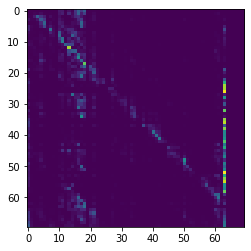

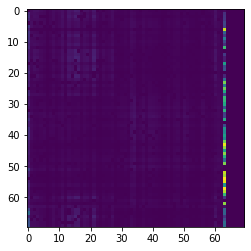

In [158]:
L = -1
plot_grid(eval(bert, batch=tbatch)[-1].attentions[L][0,1])
plot_grid(eval(approxbert, batch=tbatch, fc=lambda x:x)[-1].attentions[L][0,1])

In [160]:
def approx_eval(sparsebert, batch=batch, approxbert=approxbert, ks=[0.5,0.5,0.5,0.5]):
    attentions = eval(approxbert, batch=batch, fc=lambda x:x)[-1].attentions
    reset_input_mask(sparsebert)
    eval(sparsebert, batch=batch)
    for i, layer in enumerate(sparsebert.encoder.layer):
        assert layer.attention.self.last_attention_probs.shape == attentions[i].shape
        layer.attention.self.last_attention_probs = attentions[i]
    update_input_mask(sparsebert, ks=ks)
    ret = eval(sparsebert, batch=batch)
    return ret
#approx_eval(sparsebert)[:2]
set_print(sparsebert, False)
set_masking_timing(sparsebert, 'before_softmax')
set_output_masking(sparsebert, True)
accuracy(sparsebert, eval=approx_eval, N=1500)

 49%|████▉     | 736/1500 [00:56<00:59, 12.93it/s]


KeyboardInterrupt: 

In [168]:
lm = approx_eval(sparsebert)[-1]
torch.sum((lm.attentions[0][0,0][0] > 0.0) * 1.0), torch.sum(batch.attention_masks[0])

(tensor(17., device='cuda:0'), tensor(34, device='cuda:0'))